In [16]:
import torch

In [17]:
sd = torch.load('facebook/7B/consolidated.00.pth', map_location='cuda')

from pprint import pprint
pprint(list(sd.keys()))

new_sd = {}

reserved_keys = ['layers.0', 'tok_embeddings.weight', 'norm.weight', 'output.weight']
for k, v in sd.items():
    if any(k.startswith(kk) for kk in reserved_keys):
        new_sd[k] = v


pprint(list(new_sd.keys()))

torch.save(new_sd, 'single.pth')

sd['output.weight'].shape


sd['layers.0.attention_norm.weight'].shape

sd['layers.0.attention.wq.weight'].shape

In [18]:
new_sd = {}
for i in range(32):
    new_sd[f'layers.{i}.attention.wq.weight'] = sd[f'layers.{i}.attention.wq.weight'] * sd[f'layers.{i}.attention_norm.weight']
    new_sd[f'layers.{i}.attention.wk.weight'] = sd[f'layers.{i}.attention.wk.weight'] * sd[f'layers.{i}.attention_norm.weight']
    new_sd[f'layers.{i}.attention.wv.weight'] = sd[f'layers.{i}.attention.wv.weight'] * sd[f'layers.{i}.attention_norm.weight']
    new_sd[f'layers.{i}.attention.wo.weight'] = sd[f'layers.{i}.attention.wo.weight']
    new_sd[f'layers.{i}.feed_forward.w1.weight'] = sd[f'layers.{i}.feed_forward.w1.weight'] * sd[f'layers.{i}.ffn_norm.weight']
    new_sd[f'layers.{i}.feed_forward.w2.weight'] = sd[f'layers.{i}.feed_forward.w2.weight']
    new_sd[f'layers.{i}.feed_forward.w3.weight'] = sd[f'layers.{i}.feed_forward.w3.weight'] * sd[f'layers.{i}.ffn_norm.weight']
new_sd['output.weight'] = sd['output.weight'] * sd['norm.weight']
new_sd['tok_embeddings.weight'] = sd['tok_embeddings.weight']

In [21]:
import torch
import copy

norm_fuse_sd = copy.copy(new_sd)

for i in range(32):
    for layer in ['wq', 'wk', 'wv']:
        fname = f'layers.{i}.attention.{layer}.weight'
        w = norm_fuse_sd[fname]
        norm = torch.linalg.vector_norm(w, dim=-1, keepdim=True) / 64
        norm_fuse_sd[fname] = w / norm

torch.save(new_sd, 'full_fused.pth')

In [22]:
def stat(x, dim=None):
    return x.mean(dim), x.std(dim), x.amin(dim), x.amax(dim), x.abs().amax(dim)

In [25]:
def outliers_stat(x, dim=None):
    mean, std, amin, amax, absmax = stat(x, dim)
    absmax = torch.maximum(torch.abs(amin), torch.abs(amax))
    std = absmax.std()
    sigma1 = (absmax.mean()+2*std)
    thre = sigma1
    num_outliers = (absmax > thre).sum()
    idx_outliers = (absmax > thre).nonzero(as_tuple=True)[0]
    return num_outliers, idx_outliers

In [26]:
name = ['ori', 'fuse']
for i in range(32):
    for j, lname in enumerate(('wq', 'wk')):
        lname = f'layers.{i}.attention.{lname}.weight'
        num_outliers, idx_outliers = outliers_stat(new_sd[lname], 0)
        print(lname, num_outliers.item())
        print(idx_outliers)

layers.0.attention.wq.weight 52
tensor([ 261,  291,  338,  625,  830,  844, 1111, 1199, 1222, 1368, 1418, 1426,
        1487, 1558, 1602, 1665, 1697, 2046, 2077, 2153, 2160, 2195, 2239, 2249,
        2250, 2293, 2317, 2318, 2327, 2519, 2558, 2664, 2746, 2773, 2785, 2787,
        2827, 2926, 3037, 3131, 3194, 3447, 3473, 3566, 3577, 3589, 3612, 3753,
        3794, 3814, 3832, 3840], device='cuda:0')
layers.0.attention.wk.weight 52
tensor([ 261,  291,  338,  625,  830,  844, 1111, 1199, 1222, 1368, 1418, 1426,
        1487, 1558, 1602, 1665, 1697, 2046, 2077, 2153, 2160, 2195, 2239, 2249,
        2250, 2293, 2317, 2318, 2327, 2519, 2558, 2664, 2746, 2773, 2785, 2787,
        2827, 2926, 3037, 3116, 3131, 3194, 3447, 3473, 3566, 3577, 3589, 3612,
        3753, 3794, 3814, 3832], device='cuda:0')
layers.1.attention.wq.weight 195
tensor([   9,   32,   35,   45,   64,   86,  112,  133,  141,  145,  152,  167,
         168,  190,  195,  204,  207,  235,  244,  274,  296,  299,  324,  330,
   

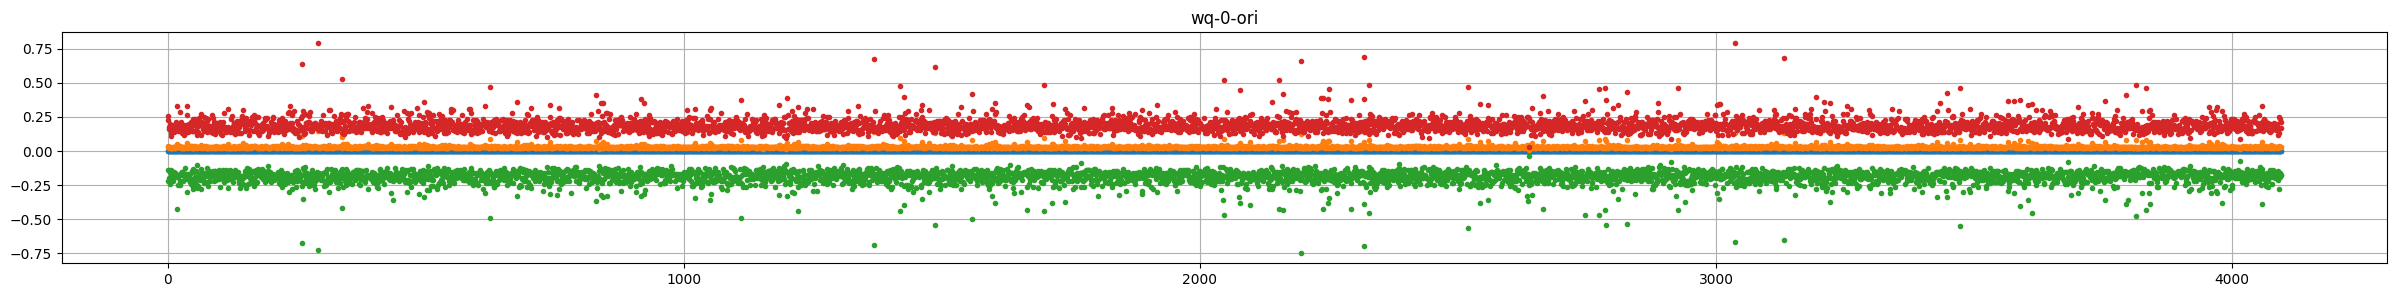

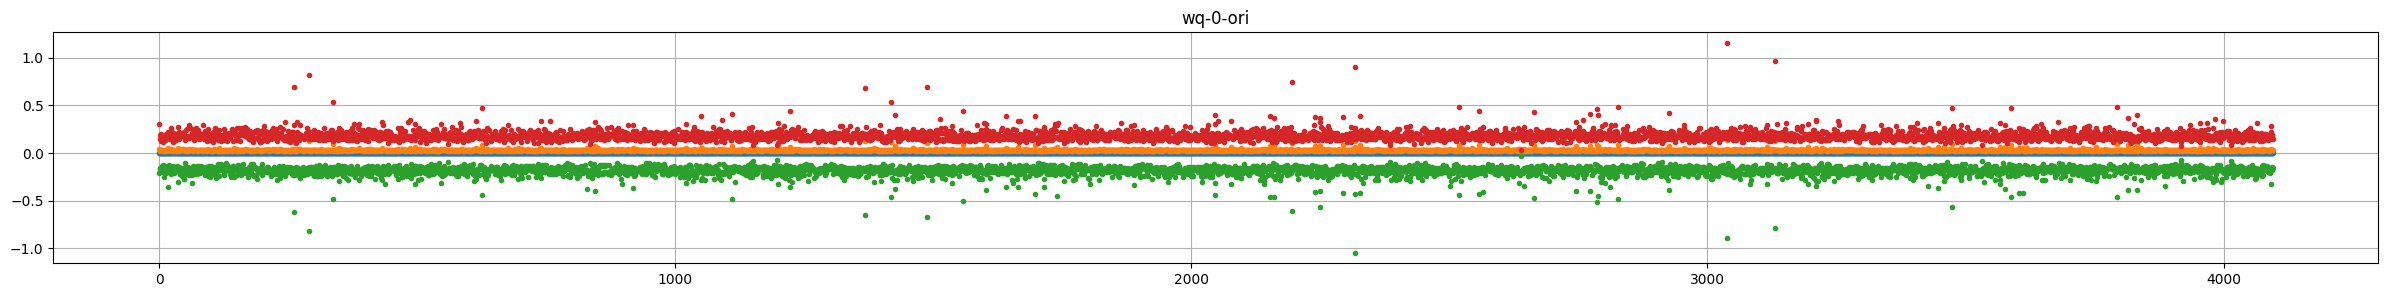

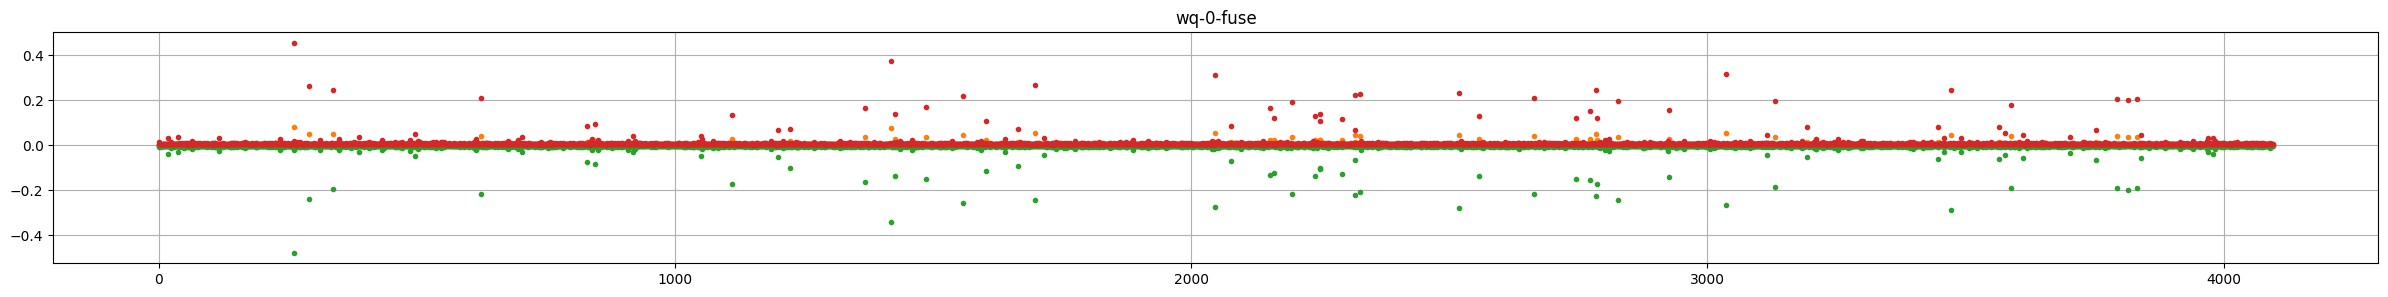

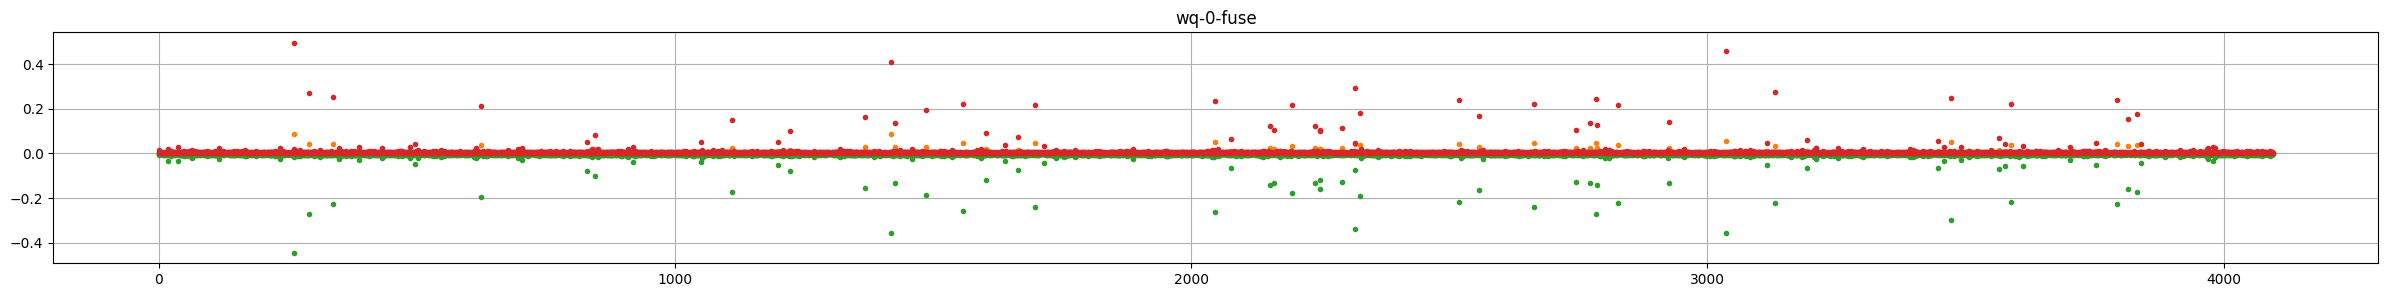

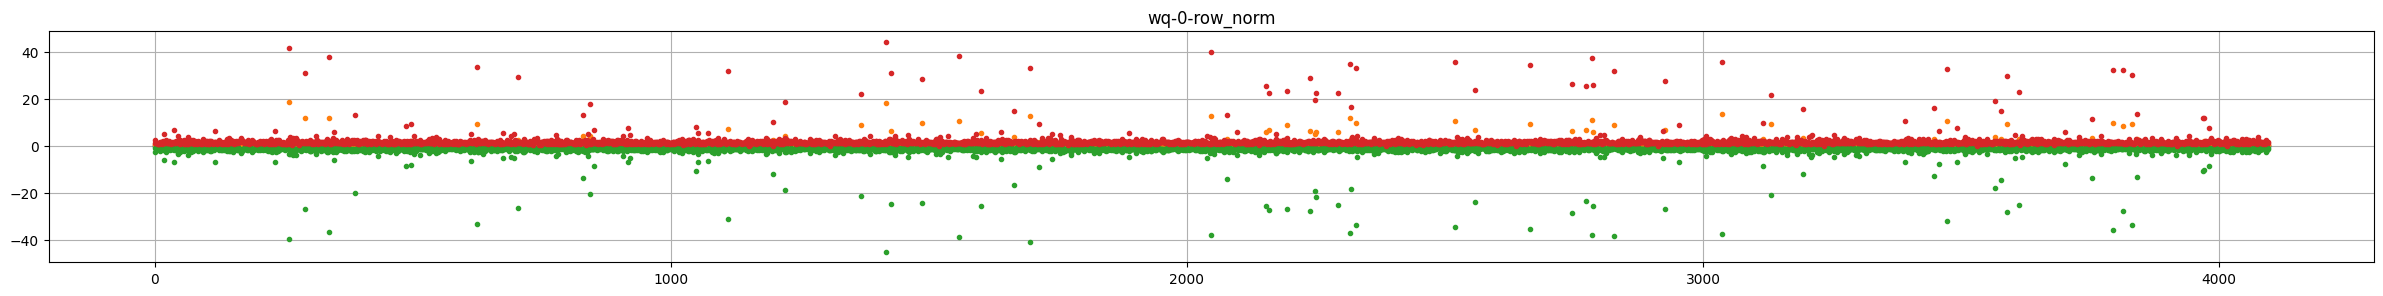

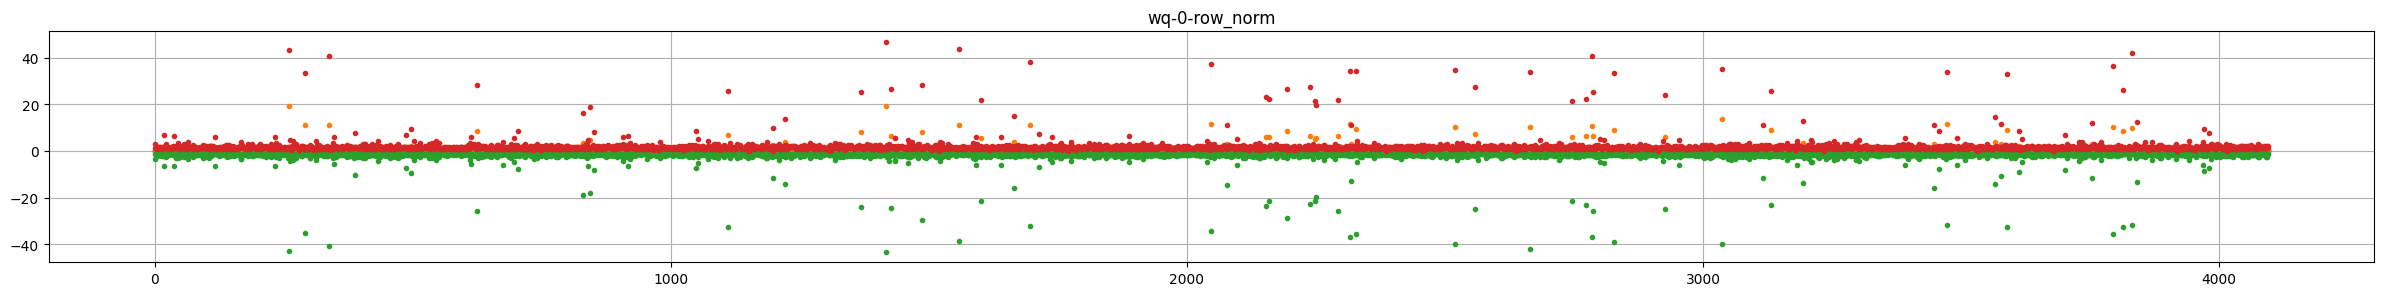

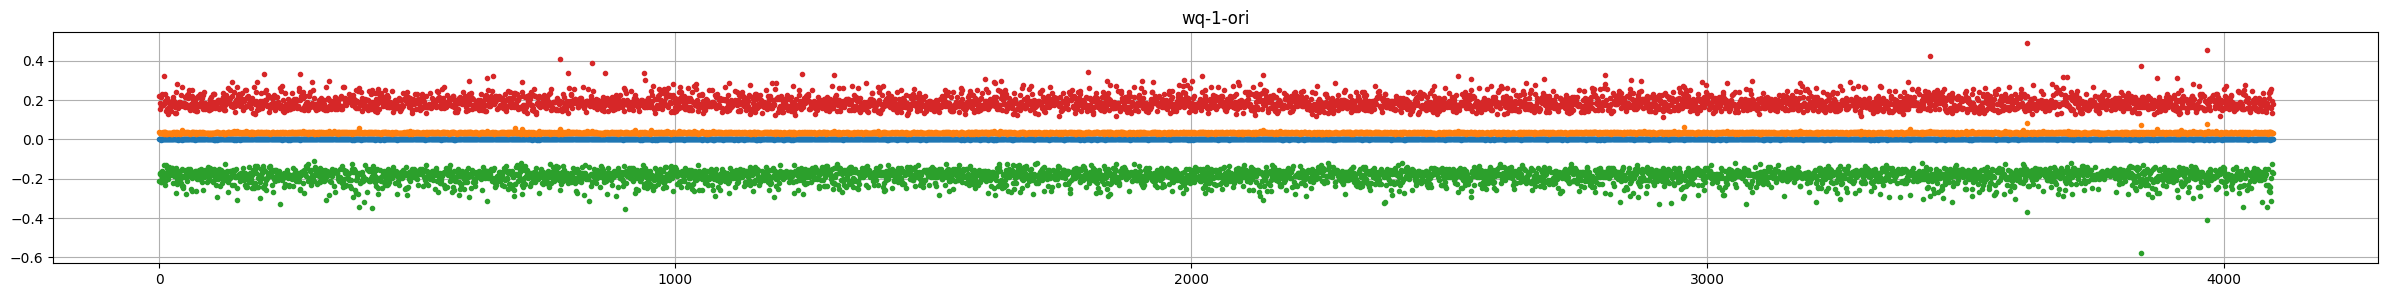

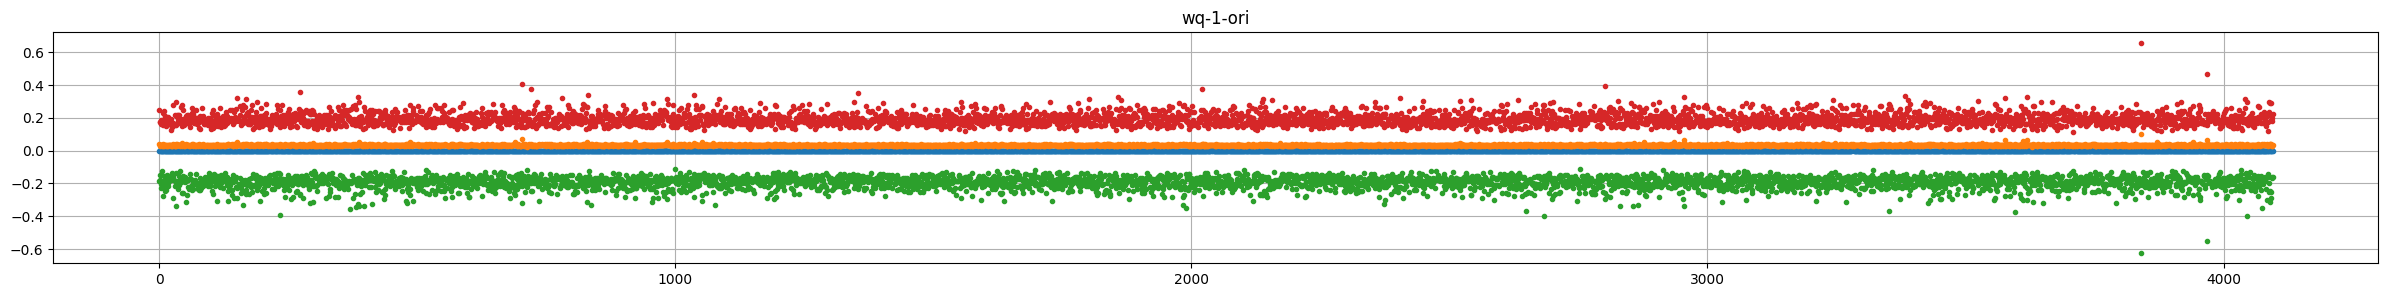

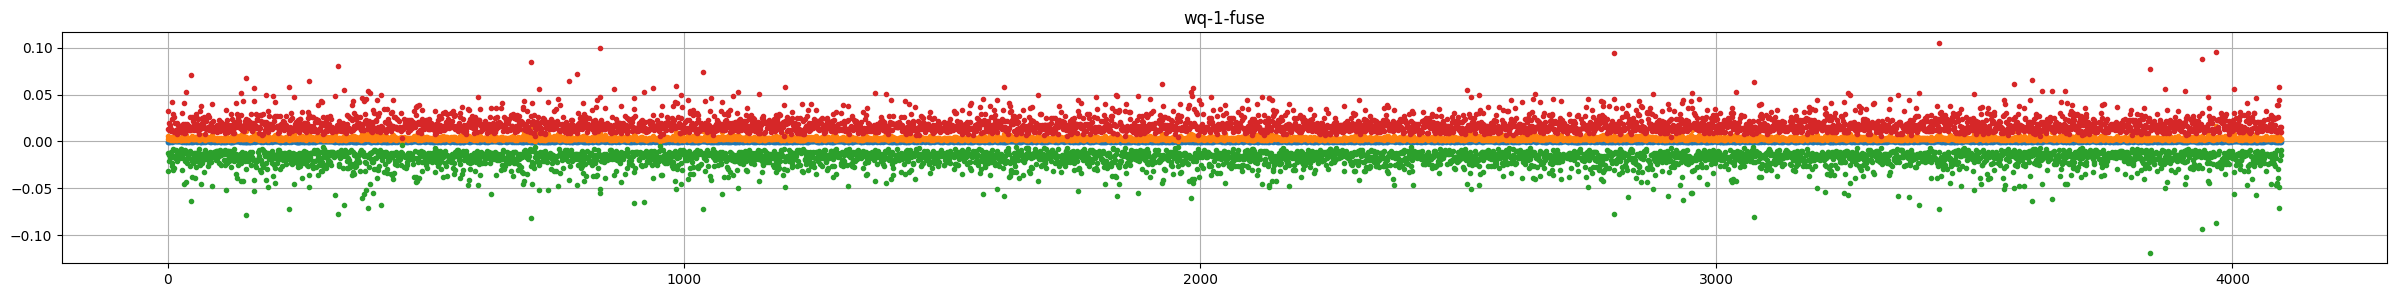

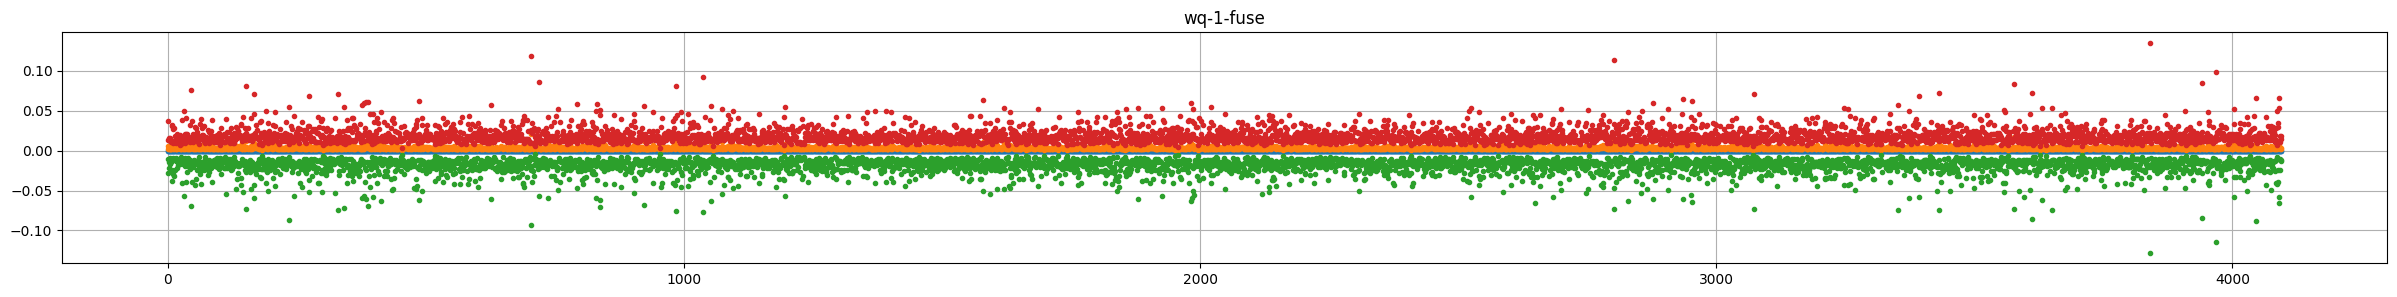

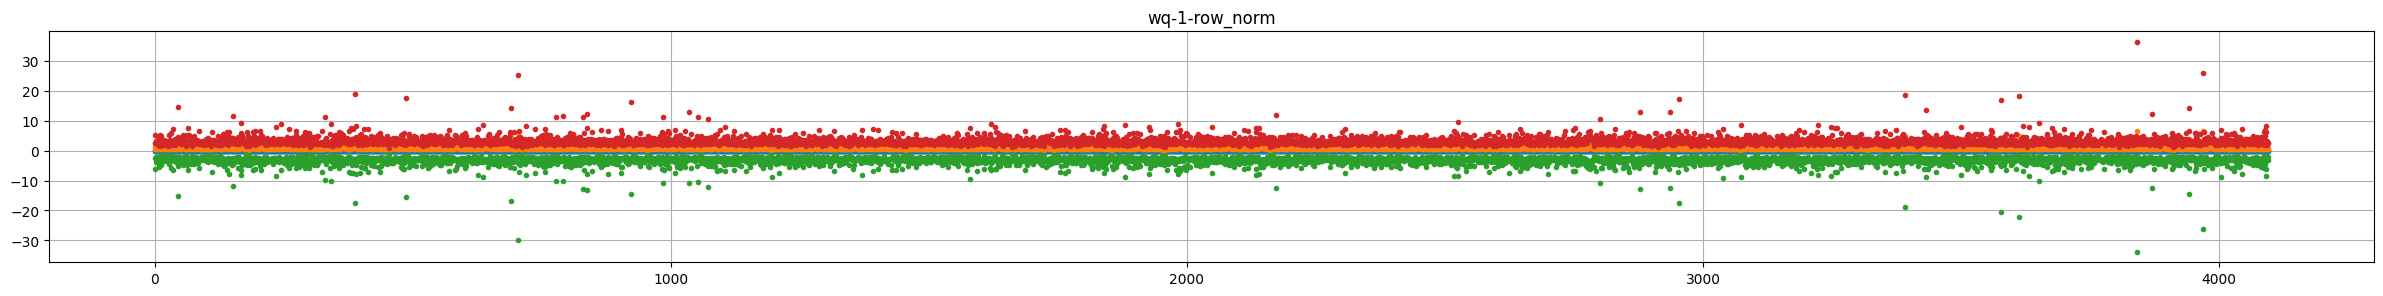

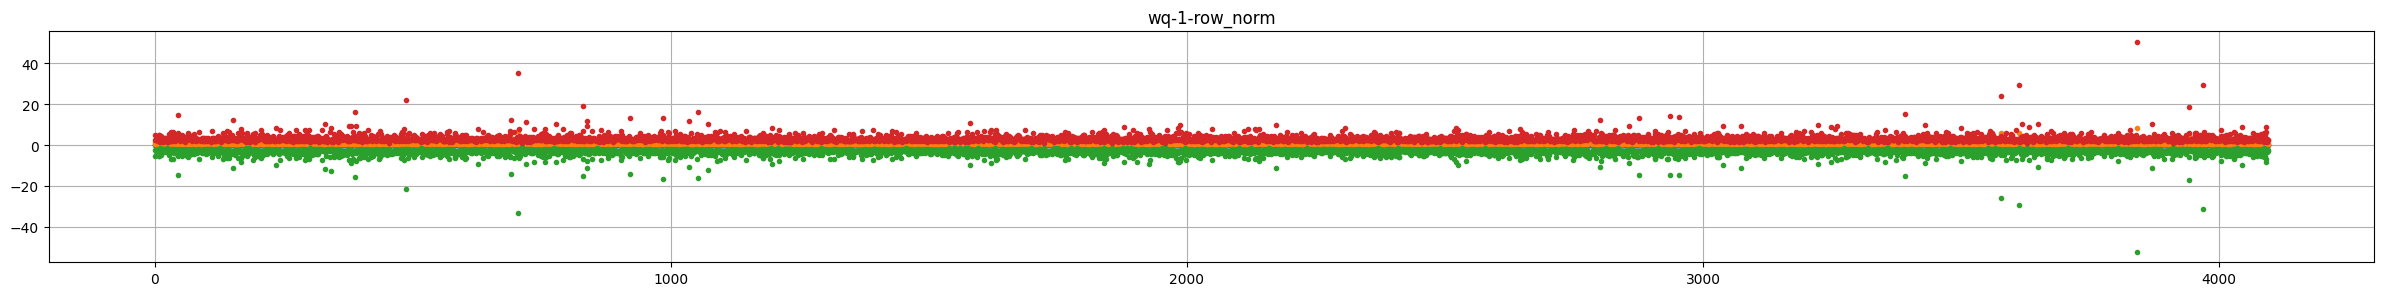

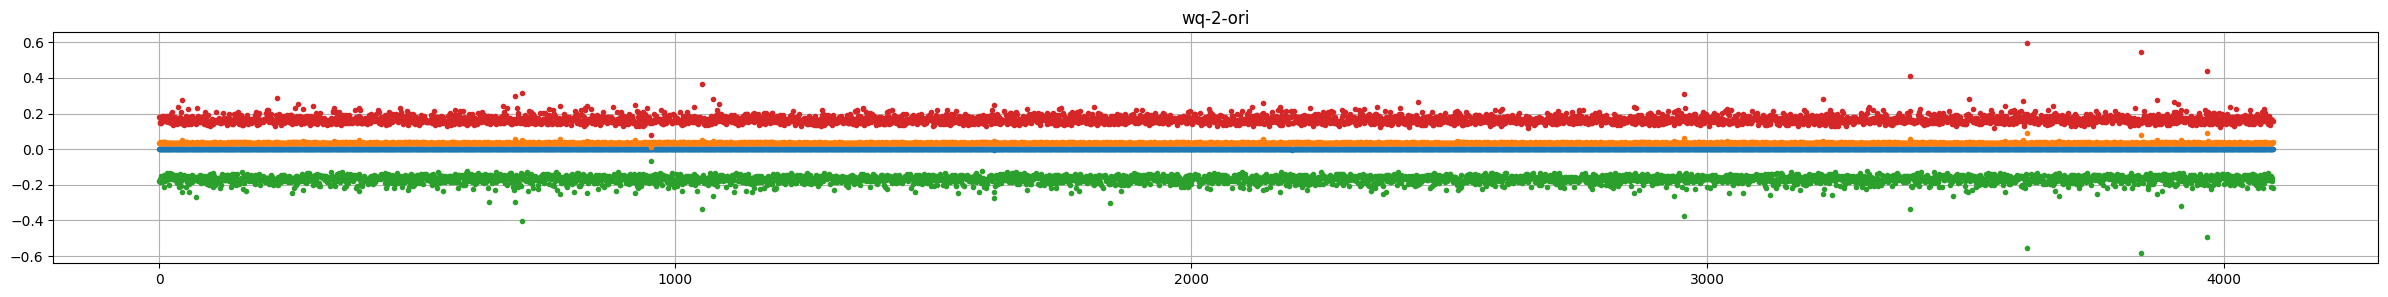

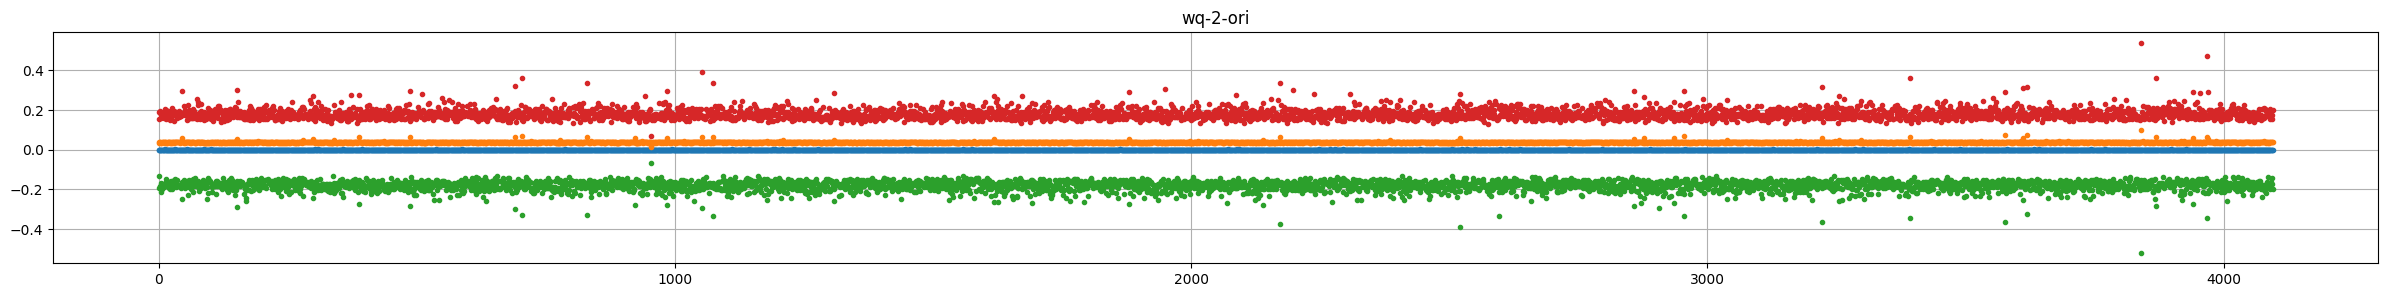

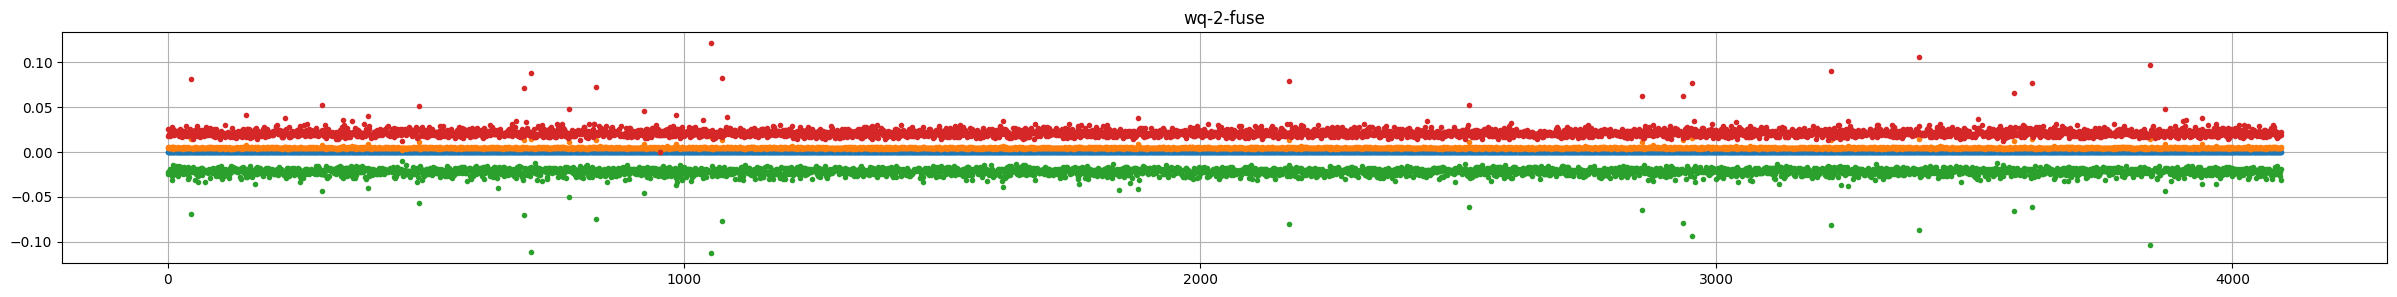

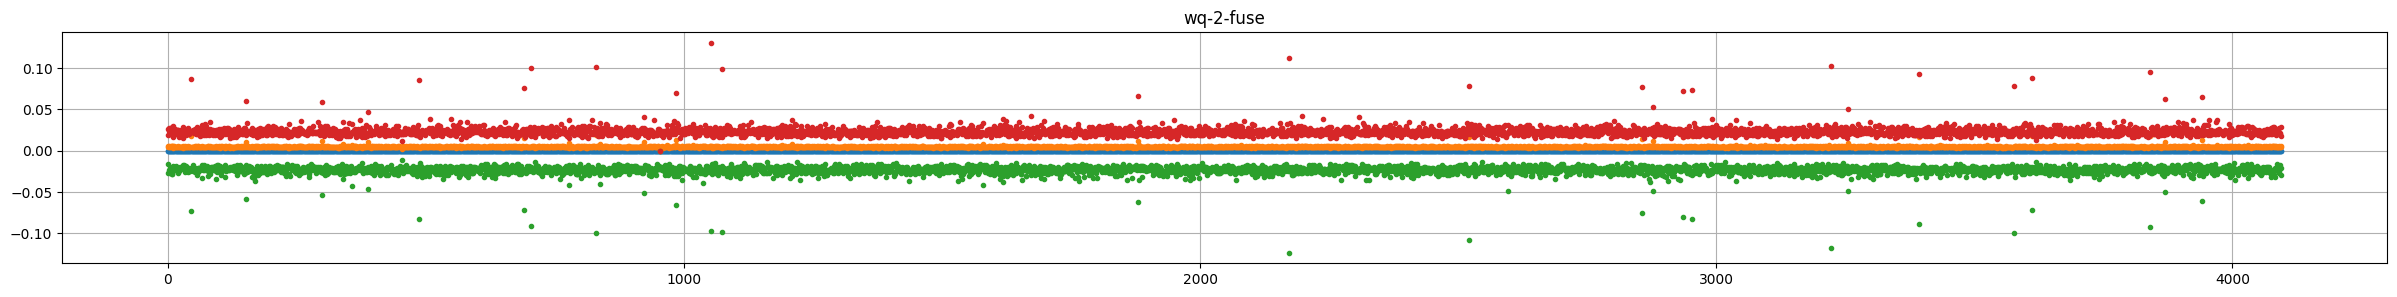

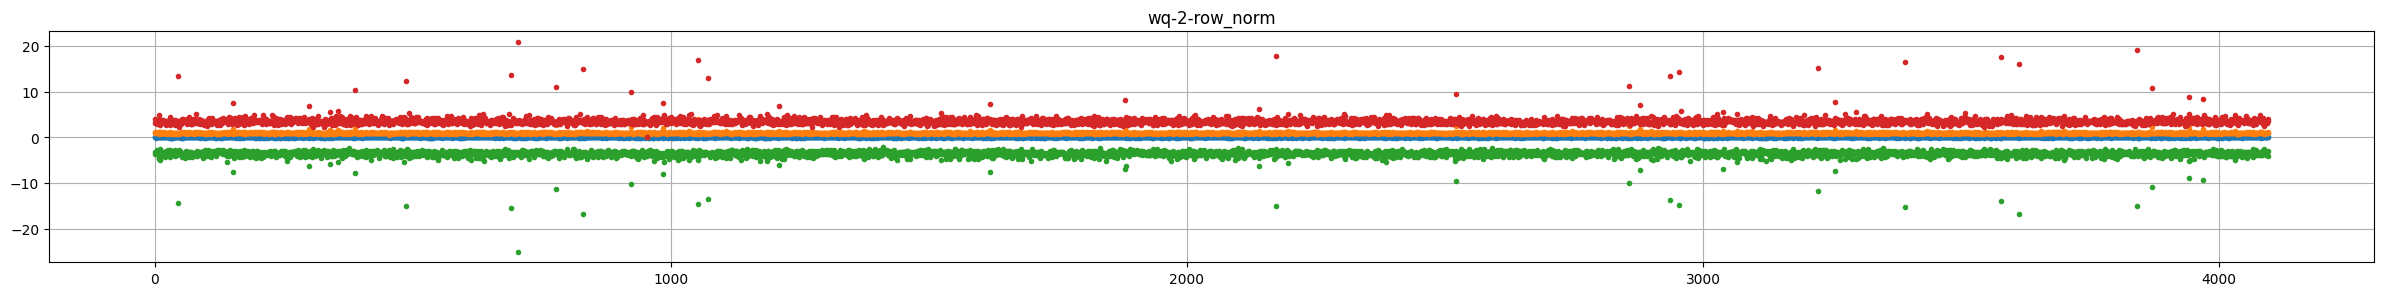

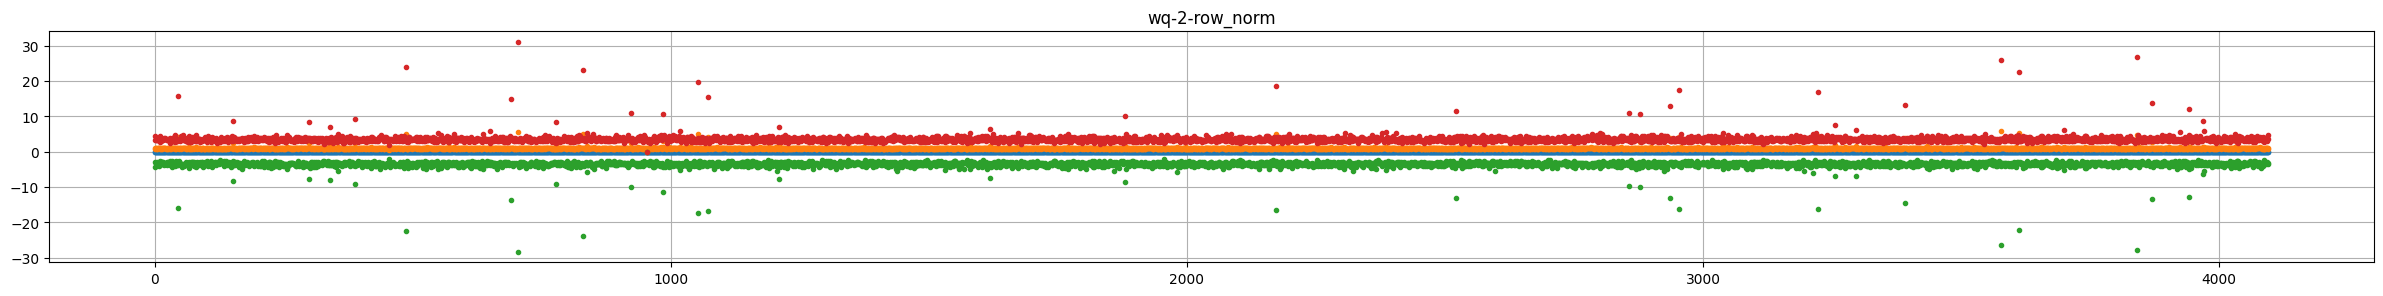

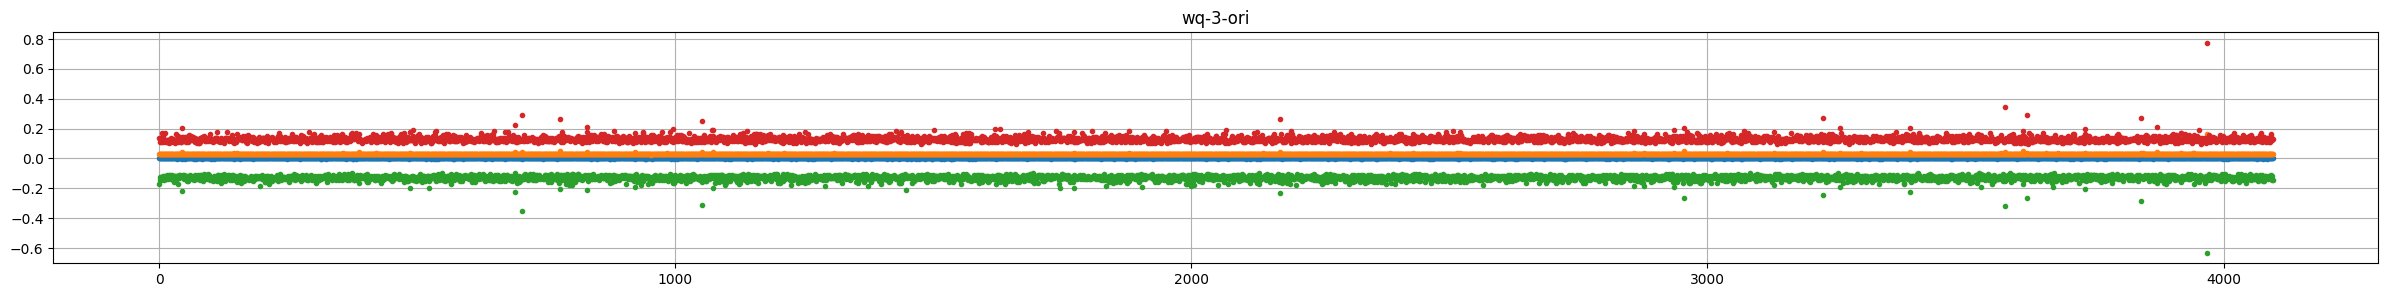

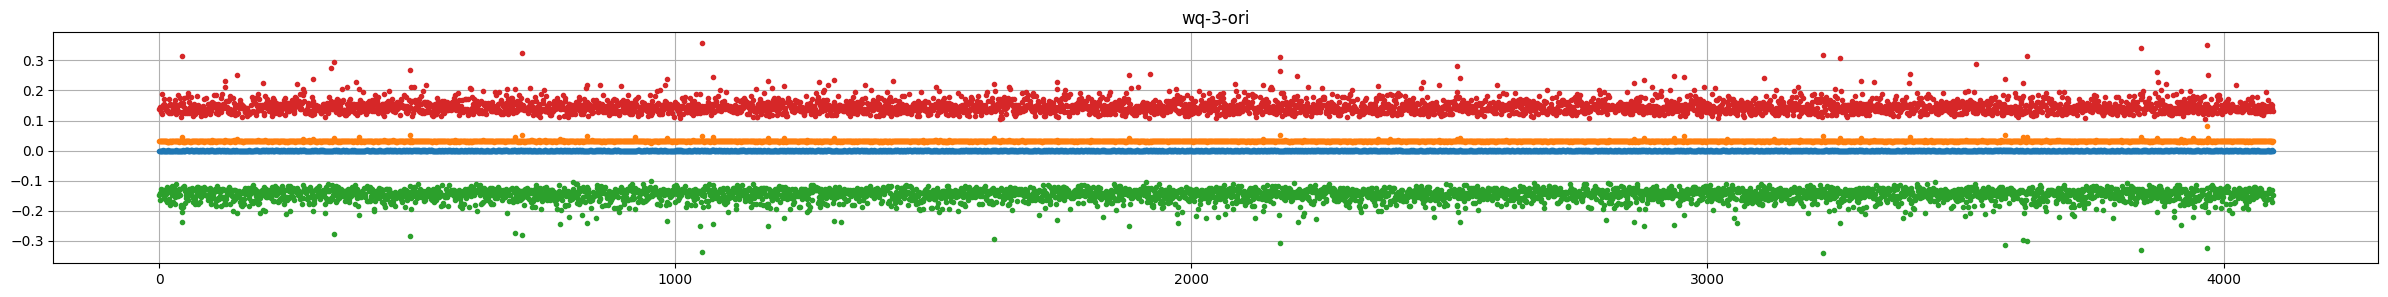

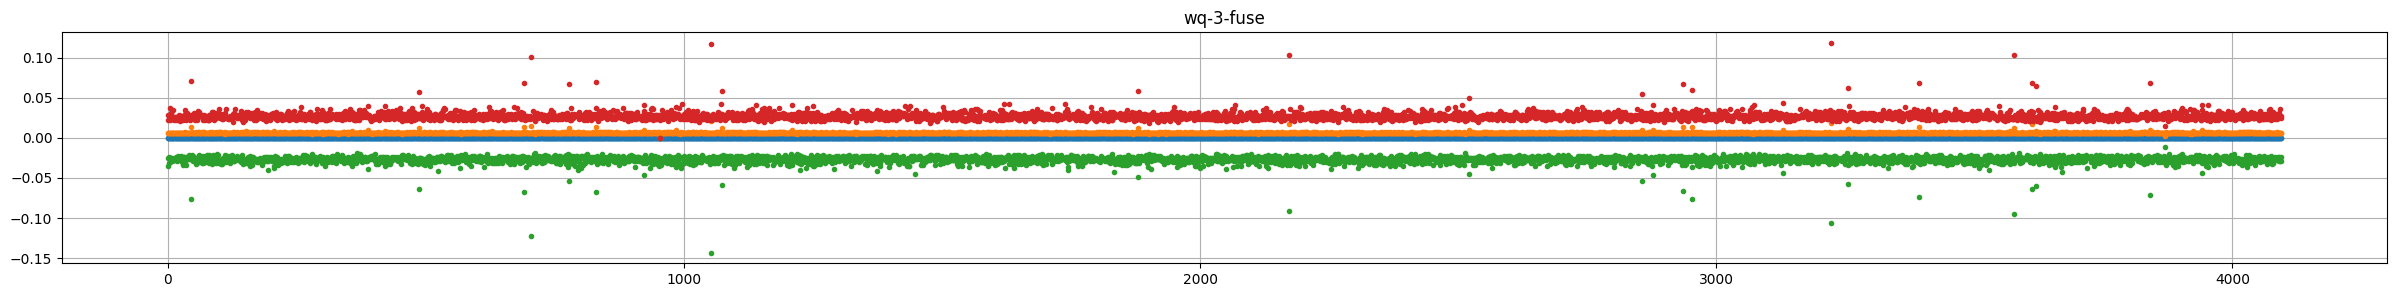

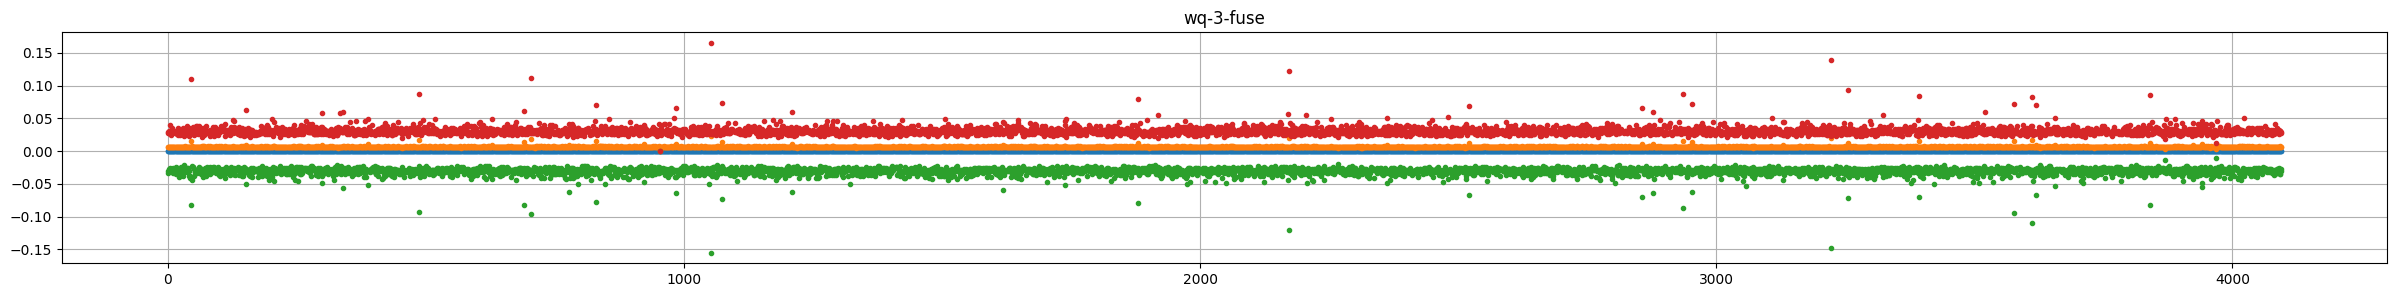

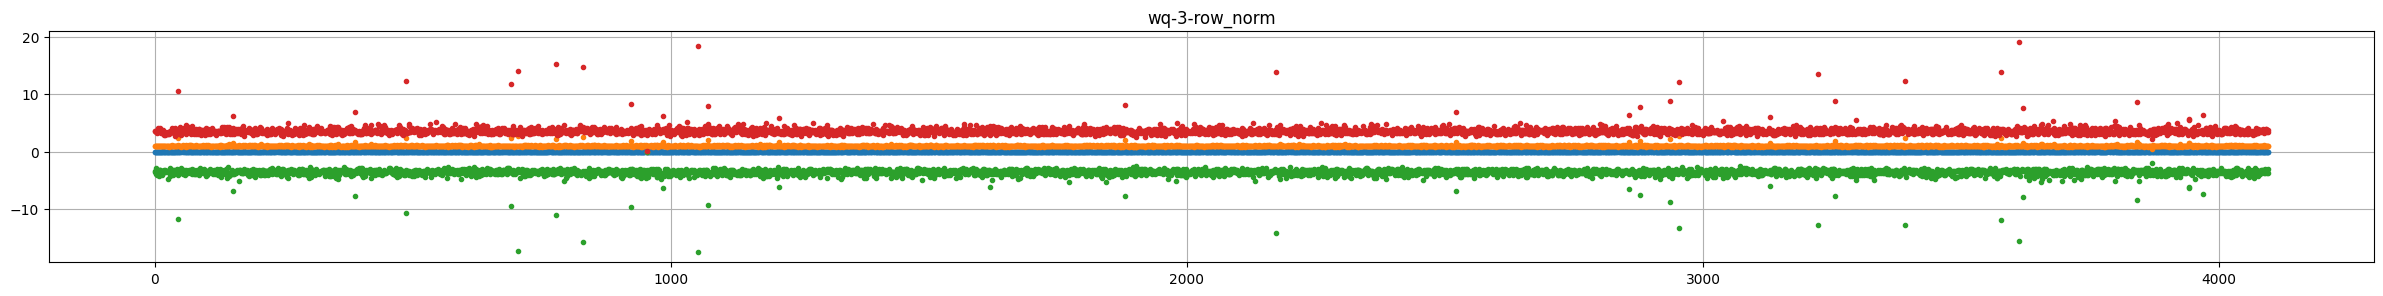

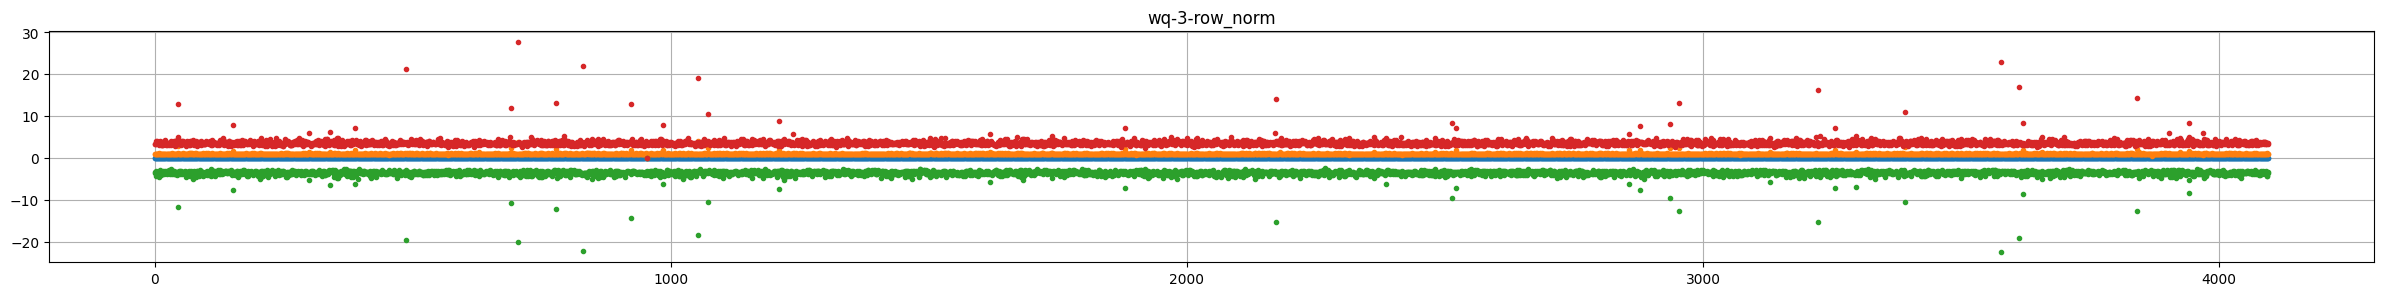

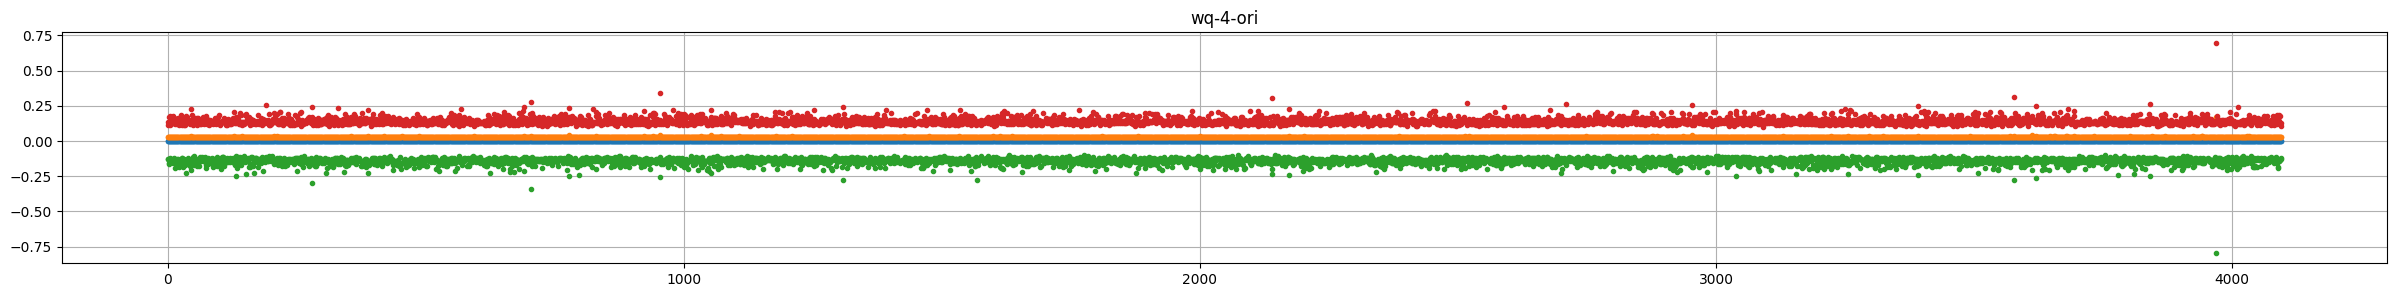

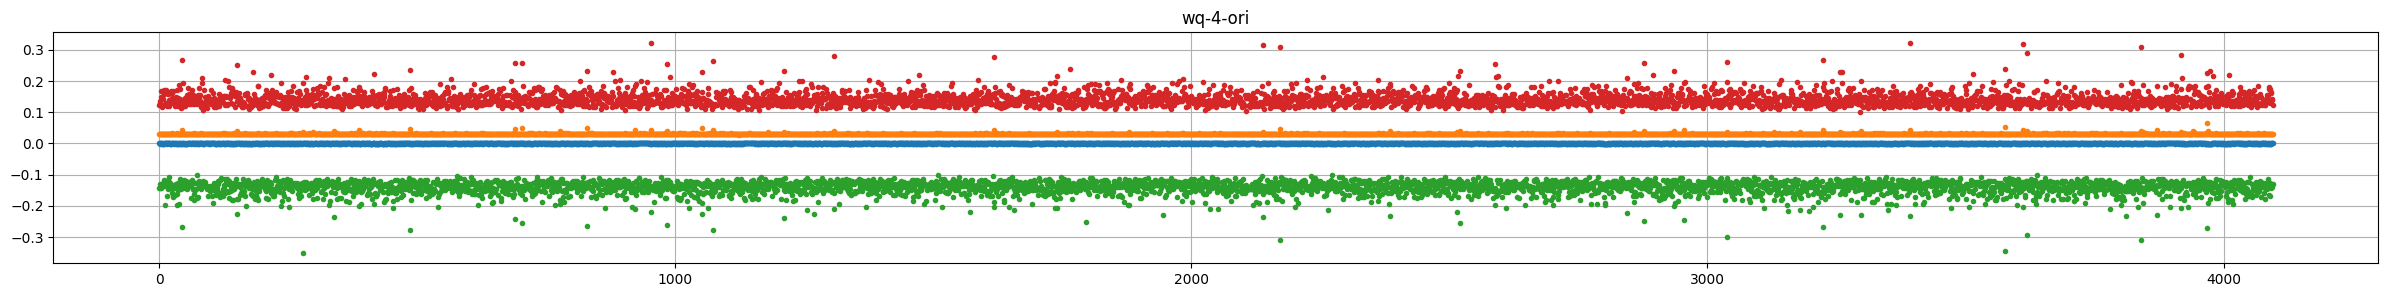

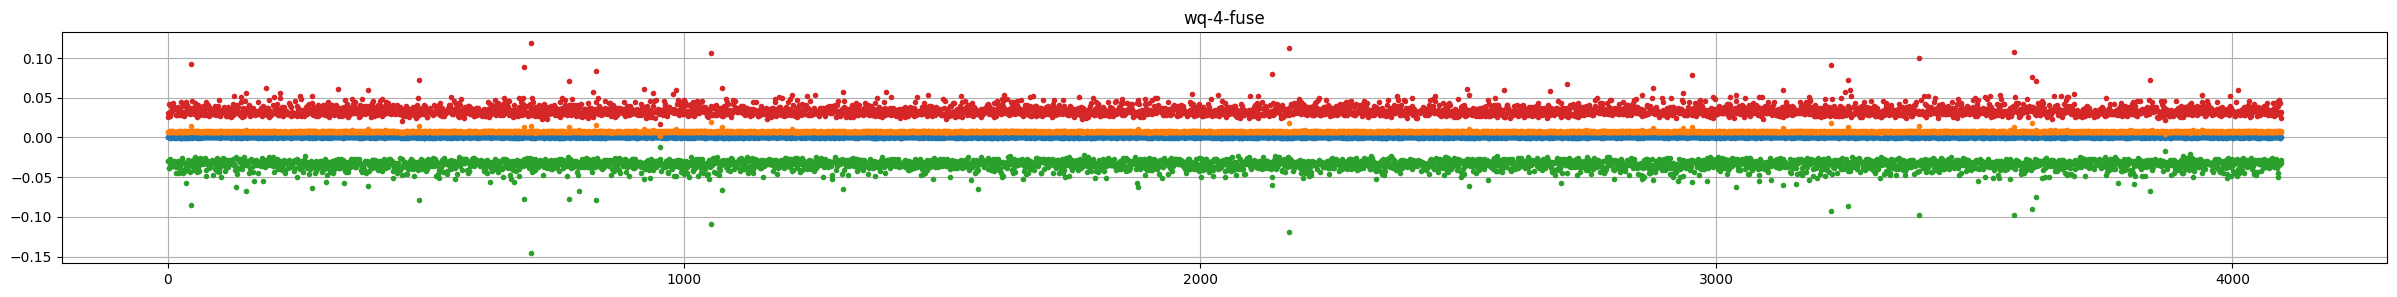

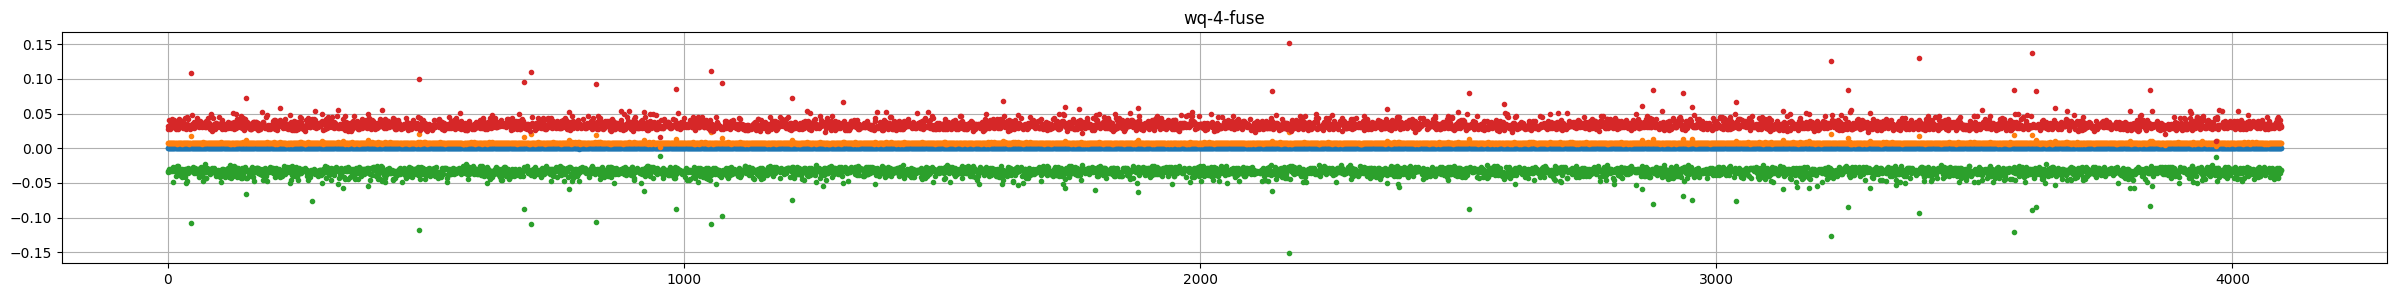

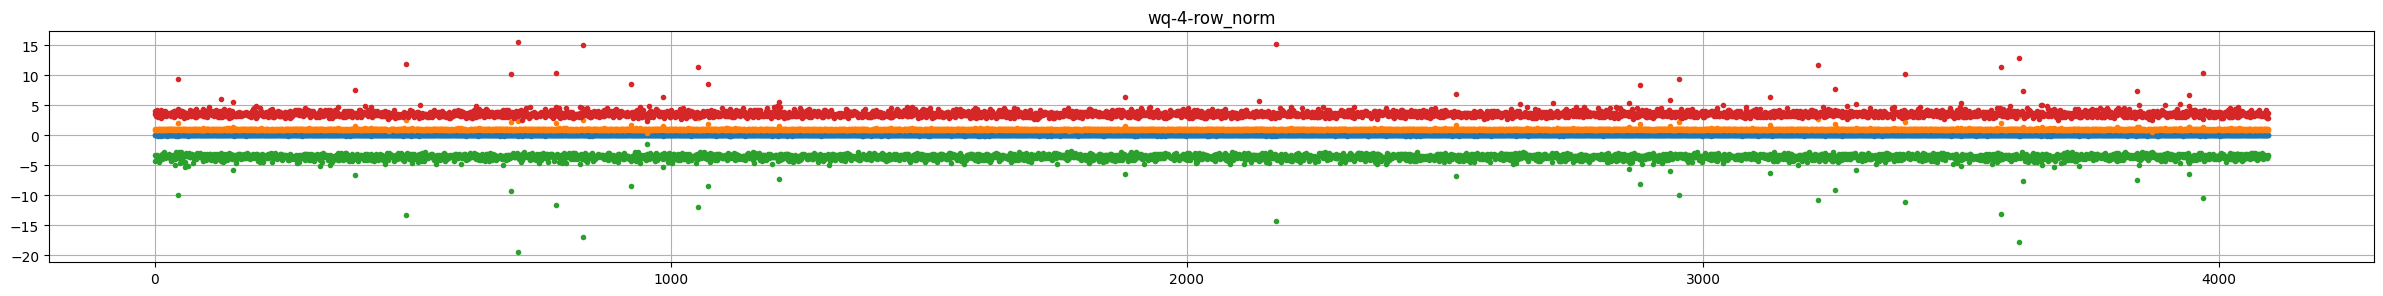

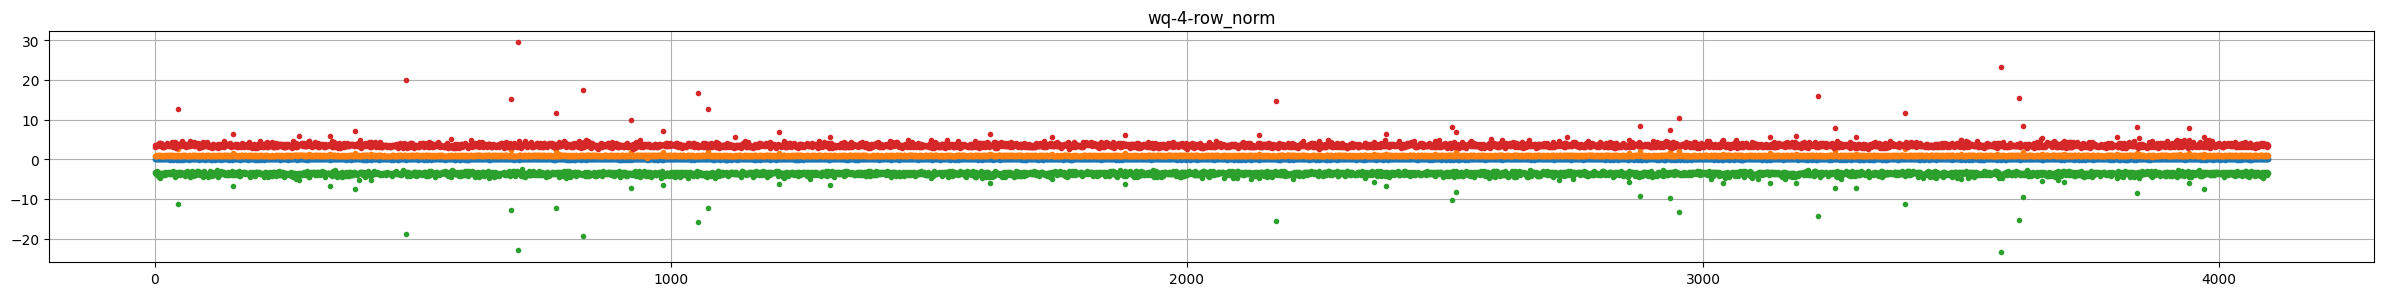

In [28]:
import matplotlib.pyplot as plt

name = ['ori', 'fuse', 'row_norm']
for i in range(5):
    for j, d in enumerate((sd, new_sd, norm_fuse_sd)):
        for k, lname in enumerate(('wq', 'wk')):
            full_name = f'layers.{i}.attention.{lname}.weight'
            mean, std, amin, amax, absmax = stat(d[full_name], 0)
            plt.figure(figsize=(30,3))
            plt.plot(mean.cpu().numpy(), '.')
            plt.plot(std.cpu().numpy(), '.')
            plt.plot(amin.cpu().numpy(), '.')
            plt.plot(amax.cpu().numpy(), '.')
            # plt.xlim(-10, 1024)
            plt.grid(which='both')
            title = f'{lname}-{i}-{name[j]}'
            plt.title(title)
            plt.show()
            plt.close()
            # plt.figure(figsize=(30,3))
            # plt.plot((std/absmax).cpu().numpy(), '.')
            # # plt.xlim(-10, 1024)
            # plt.grid(which='both')
            # title = f'wq-{i}-{name[j]}-norm'
            # plt.title(title)
            # plt.show()
            # plt.close()

In [ ]:
mean, std, amin, amax = stat(sd['layers.0.attention.wq.weight'], 1)

In [ ]:
plt.figure(figsize=(25,5))
plt.boxplot(sd['layers.0.attention.wq.weight'].cpu().numpy())
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(25,5))
plt.boxplot(new_sd['layers.0.attention.wq.weight'].cpu().numpy())
plt.show()
plt.close()